<a href="https://colab.research.google.com/github/Arru2003/Alzheimer-detection/blob/main/MobileNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install necessary libraries
!pip install gradio opencv-python tensorflow numpy matplotlib scikit-learn gdown albumentations -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.6 MB/s eta 0:00:00


In [2]:
# Imports
import os
import numpy as np
import pandas as pd
import cv2
import random
import matplotlib.pyplot as plt
import datetime
import zipfile

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from tensorflow.keras.applications import MobileNetV2
import albumentations as A

import gradio as gr

# Seed
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


In [3]:
# Download and extract dataset
!gdown --id 1vCWykHw2CxTwOpbHFN7Ke5z5a34q8Ze3 -O data.zip
with zipfile.ZipFile("data.zip", 'r') as zip_ref:
    zip_ref.extractall("dataset")

DATASET_PATH = "dataset"
IMG_SIZE = 128

file_paths, labels = [], []
for label in os.listdir(DATASET_PATH):
    class_dir = os.path.join(DATASET_PATH, label)
    for fname in os.listdir(class_dir):
        file_paths.append(os.path.join(class_dir, fname))
        labels.append(label)


/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1vCWykHw2CxTwOpbHFN7Ke5z5a34q8Ze3
From (redirected): https://drive.google.com/uc?id=1vCWykHw2CxTwOpbHFN7Ke5z5a34q8Ze3&confirm=t&uuid=a4aeddc0-f693-4bd8-984c-2d4580bd64d8
To: /content/data.zip
100% 1.32G/1.32G [00:17<00:00, 77.1MB/s]


In [4]:
# Label Encoding
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)
labels_cat = to_categorical(labels_encoded)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(labels_encoded), y=labels_encoded)
class_weights = dict(enumerate(class_weights))


In [5]:
class MRIDataGenerator(Sequence):
    def __init__(self, file_paths, labels, batch_size=32, img_size=128, augment=False, shuffle=True):
        self.file_paths = file_paths
        self.labels = labels
        self.batch_size = batch_size
        self.img_size = img_size
        self.augment = augment
        self.shuffle = shuffle
        self.on_epoch_end()

        self.transform = A.Compose([
            A.Resize(self.img_size, self.img_size),
            A.OneOf([
                A.HorizontalFlip(p=0.5),
                A.RandomRotate90(p=0.5),
                A.ShiftScaleRotate(p=0.5),
                A.RandomBrightnessContrast(p=0.5),
                A.CLAHE(p=0.5),
                A.HueSaturationValue(p=0.5)
            ], p=0.7),
            A.Normalize()
        ])

    def __len__(self):
        return int(np.ceil(len(self.file_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_paths = self.file_paths[index * self.batch_size:(index + 1) * self.batch_size]
        batch_labels = self.labels[index * self.batch_size:(index + 1) * self.batch_size]

        images = []
        for path in batch_paths:
            img = cv2.imread(path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            if self.augment:
                img = self.transform(image=img)['image']
            else:
                img = cv2.resize(img, (self.img_size, self.img_size)) / 255.0
            images.append(img)

        return np.array(images), np.array(batch_labels)

    def on_epoch_end(self):
        if self.shuffle:
            zipped = list(zip(self.file_paths, self.labels))
            random.shuffle(zipped)
            self.file_paths, self.labels = zip(*zipped)


In [6]:
def build_mobilenet_model(input_shape=(128, 128, 3), num_classes=4, fine_tune_at=80):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = True

    # Gradual unfreezing
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax', name='final_output')(x)

    model = Model(inputs=base_model.input, outputs=output)
    return model


In [7]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)
fold = 1
all_histories = []

for train_idx, val_idx in skf.split(file_paths, labels_encoded):
    print(f"\n📂 Training Fold {fold}")

    # Prepare train/val sets
    train_files = [file_paths[i] for i in train_idx]
    val_files = [file_paths[i] for i in val_idx]
    train_labels = to_categorical([labels_encoded[i] for i in train_idx])
    val_labels = to_categorical([labels_encoded[i] for i in val_idx])

    # Generators
    train_gen = MRIDataGenerator(train_files, train_labels, augment=True)
    val_gen = MRIDataGenerator(val_files, val_labels, augment=False)

    # Model
    model = build_mobilenet_model()
    model.compile(optimizer=Adam(learning_rate=0.0003),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Callbacks
    log_dir = f"logs/fold_{fold}_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    callbacks = [
        TensorBoard(log_dir=log_dir),
        EarlyStopping(patience=7, restore_best_weights=True),
        ModelCheckpoint(f"mobilenet_best_fold_{fold}.h5", save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1)
    ]

    # Train
    history = model.fit(train_gen,
                        validation_data=val_gen,
                        epochs=50,
                        callbacks=callbacks,
                        class_weight=class_weights)

    all_histories.append(history)
    fold += 1



📂 Training Fold 1


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
1801/1801 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.5577 - loss: 1.2046

1801/1801 ━━━━━━━━━━━━━━━━━━━━ 222s 101ms/step - accuracy: 0.5578 - loss: 1.2045 - val_accuracy: 0.4205 - val_loss: 1.1151 - learning_rate: 3.0000e-04
Epoch 2/50
1801/1801 ━━━━━━━━━━━━━━━━━━━━ 145s 81ms/step - accuracy: 0.6915 - loss: 0.6891 - val_accuracy: 0.0325 - val_loss: 5.4571 - learning_rate: 3.0000e-04
Epoch 3/50
1801/1801 ━━━━━━━━━━━━━━━━━━━━ 148s 82ms/step - accuracy: 0.7450 - loss: 0.5291 - val_accuracy: 0.4858 - val_loss: 2.2600 - learning_rate: 3.0000e-04
Epoch 4/50
1801/1801 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.7571 - loss: 0.5079
Epoch 4: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
1801/1801 ━━━━━━━━━━━━━━━━━━━━ 147s 82ms/step - accuracy: 0.7571 - loss: 0.5079 - val_accuracy: 0.0351 - val_loss: 5.3130 - learning_rate: 3.0000e-04
Epoch 5/50
1801/1801 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.7321 - loss: 0.4306

1801/1801 ━━━━━━━━━━━━━━━━━━━━ 149s 83ms/step - accuracy: 0.7321 - loss: 0.4306 - val_accuracy: 0.7211 - val_loss: 0.9047 - learning_rate: 9.0000e-05
Epoch 6/50
1801/1801 ━━━━━━━━━━━━━━━━━━━━ 149s 82ms/step - accuracy: 0.8584 - loss: 0.2601 - val_accuracy: 0.7336 - val_loss: 1.0504 - learning_rate: 9.0000e-05
Epoch 7/50
1801/1801 ━━━━━━━━━━━━━━━━━━━━ 242s 105ms/step - accuracy: 0.8825 - loss: 0.2294 - val_accuracy: 0.7174 - val_loss: 0.9376 - learning_rate: 9.0000e-05
Epoch 8/50
1801/1801 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8829 - loss: 0.2312
Epoch 8: ReduceLROnPlateau reducing learning rate to 2.700000040931627e-05.
1801/1801 ━━━━━━━━━━━━━━━━━━━━ 146s 81ms/step - accuracy: 0.8829 - loss: 0.2312 - val_accuracy: 0.7250 - val_loss: 0.9341 - learning_rate: 9.0000e-05
Epoch 9/50
1801/1801 ━━━━━━━━━━━━━━━━━━━━ 150s 83ms/step - accuracy: 0.9084 - loss: 0.1663 - val_accuracy: 0.6997 - val_loss: 0.9298 - learning_rate: 2.7000e-05
Epoch 10/50
1801/1801 ━━━━━━━━━━━━━━━━━━━━ 143s 80m

1801/1801 ━━━━━━━━━━━━━━━━━━━━ 192s 93ms/step - accuracy: 0.5626 - loss: 1.1757 - val_accuracy: 0.1543 - val_loss: 2.2310 - learning_rate: 3.0000e-04
Epoch 2/50
1801/1801 ━━━━━━━━━━━━━━━━━━━━ 147s 81ms/step - accuracy: 0.6894 - loss: 0.6899 - val_accuracy: 0.2535 - val_loss: 2.9723 - learning_rate: 3.0000e-04
Epoch 3/50
1801/1801 ━━━━━━━━━━━━━━━━━━━━ 148s 82ms/step - accuracy: 0.7300 - loss: 0.6108 - val_accuracy: 0.3080 - val_loss: 2.2723 - learning_rate: 3.0000e-04
Epoch 4/50
1801/1801 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.7309 - loss: 0.5514
Epoch 4: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
1801/1801 ━━━━━━━━━━━━━━━━━━━━ 142s 79ms/step - accuracy: 0.7309 - loss: 0.5514 - val_accuracy: 0.7734 - val_loss: 3.2223 - learning_rate: 3.0000e-04
Epoch 5/50
1801/1801 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.7879 - loss: 0.3954

1801/1801 ━━━━━━━━━━━━━━━━━━━━ 190s 106ms/step - accuracy: 0.7879 - loss: 0.3954 - val_accuracy: 0.7573 - val_loss: 1.0041 - learning_rate: 9.0000e-05
Epoch 6/50
1801/1801 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8337 - loss: 0.3002

1801/1801 ━━━━━━━━━━━━━━━━━━━━ 146s 81ms/step - accuracy: 0.8337 - loss: 0.3002 - val_accuracy: 0.7562 - val_loss: 0.9008 - learning_rate: 9.0000e-05
Epoch 7/50
1801/1801 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8653 - loss: 0.2451

1801/1801 ━━━━━━━━━━━━━━━━━━━━ 148s 82ms/step - accuracy: 0.8653 - loss: 0.2451 - val_accuracy: 0.7591 - val_loss: 0.6868 - learning_rate: 9.0000e-05
Epoch 8/50
1801/1801 ━━━━━━━━━━━━━━━━━━━━ 142s 79ms/step - accuracy: 0.8837 - loss: 0.2201 - val_accuracy: 0.6172 - val_loss: 0.8339 - learning_rate: 9.0000e-05
Epoch 9/50
1801/1801 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8821 - loss: 0.2195

1801/1801 ━━━━━━━━━━━━━━━━━━━━ 151s 84ms/step - accuracy: 0.8821 - loss: 0.2195 - val_accuracy: 0.7814 - val_loss: 0.6094 - learning_rate: 9.0000e-05
Epoch 10/50
1801/1801 ━━━━━━━━━━━━━━━━━━━━ 188s 105ms/step - accuracy: 0.9051 - loss: 0.1769 - val_accuracy: 0.7784 - val_loss: 0.8457 - learning_rate: 9.0000e-05
Epoch 11/50
1801/1801 ━━━━━━━━━━━━━━━━━━━━ 147s 81ms/step - accuracy: 0.9102 - loss: 0.1710 - val_accuracy: 0.7808 - val_loss: 0.9876 - learning_rate: 9.0000e-05
Epoch 12/50
1801/1801 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9155 - loss: 0.1593
Epoch 12: ReduceLROnPlateau reducing learning rate to 2.700000040931627e-05.
1801/1801 ━━━━━━━━━━━━━━━━━━━━ 148s 82ms/step - accuracy: 0.9155 - loss: 0.1593 - val_accuracy: 0.7619 - val_loss: 0.9079 - learning_rate: 9.0000e-05
Epoch 13/50
1801/1801 ━━━━━━━━━━━━━━━━━━━━ 153s 85ms/step - accuracy: 0.9142 - loss: 0.1482 - val_accuracy: 0.7292 - val_loss: 0.6893 - learning_rate: 2.7000e-05
Epoch 14/50
1801/1801 ━━━━━━━━━━━━━━━━━━━━ 197

1801/1801 ━━━━━━━━━━━━━━━━━━━━ 182s 88ms/step - accuracy: 0.5693 - loss: 1.1486 - val_accuracy: 0.3340 - val_loss: 1.7854 - learning_rate: 3.0000e-04
Epoch 2/50
1801/1801 ━━━━━━━━━━━━━━━━━━━━ 143s 79ms/step - accuracy: 0.6735 - loss: 0.7043 - val_accuracy: 0.1260 - val_loss: 3.2388 - learning_rate: 3.0000e-04
Epoch 3/50
1801/1801 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.7278 - loss: 0.5508

1801/1801 ━━━━━━━━━━━━━━━━━━━━ 148s 82ms/step - accuracy: 0.7278 - loss: 0.5508 - val_accuracy: 0.3925 - val_loss: 1.4557 - learning_rate: 3.0000e-04
Epoch 4/50
1801/1801 ━━━━━━━━━━━━━━━━━━━━ 145s 80ms/step - accuracy: 0.7556 - loss: 0.5303 - val_accuracy: 0.2825 - val_loss: 1.7827 - learning_rate: 3.0000e-04
Epoch 5/50
1801/1801 ━━━━━━━━━━━━━━━━━━━━ 148s 82ms/step - accuracy: 0.7537 - loss: 0.5045 - val_accuracy: 0.4198 - val_loss: 2.2434 - learning_rate: 3.0000e-04
Epoch 6/50
1801/1801 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.7853 - loss: 0.4465
Epoch 6: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
1801/1801 ━━━━━━━━━━━━━━━━━━━━ 147s 81ms/step - accuracy: 0.7853 - loss: 0.4465 - val_accuracy: 0.2443 - val_loss: 3.7949 - learning_rate: 3.0000e-04
Epoch 7/50
1801/1801 ━━━━━━━━━━━━━━━━━━━━ 147s 82ms/step - accuracy: 0.8444 - loss: 0.2734 - val_accuracy: 0.2847 - val_loss: 1.5076 - learning_rate: 9.0000e-05
Epoch 8/50
1801/1801 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/st

1801/1801 ━━━━━━━━━━━━━━━━━━━━ 147s 81ms/step - accuracy: 0.8745 - loss: 0.2318 - val_accuracy: 0.3596 - val_loss: 1.3801 - learning_rate: 9.0000e-05
Epoch 9/50
1801/1801 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8962 - loss: 0.2007

1801/1801 ━━━━━━━━━━━━━━━━━━━━ 148s 82ms/step - accuracy: 0.8962 - loss: 0.2007 - val_accuracy: 0.7015 - val_loss: 0.7005 - learning_rate: 9.0000e-05
Epoch 10/50
1801/1801 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9098 - loss: 0.1730

1801/1801 ━━━━━━━━━━━━━━━━━━━━ 152s 85ms/step - accuracy: 0.9098 - loss: 0.1730 - val_accuracy: 0.7183 - val_loss: 0.6828 - learning_rate: 9.0000e-05
Epoch 11/50
1801/1801 ━━━━━━━━━━━━━━━━━━━━ 152s 85ms/step - accuracy: 0.9175 - loss: 0.1595 - val_accuracy: 0.7171 - val_loss: 0.8246 - learning_rate: 9.0000e-05
Epoch 12/50
1801/1801 ━━━━━━━━━━━━━━━━━━━━ 144s 80ms/step - accuracy: 0.9173 - loss: 0.1448 - val_accuracy: 0.5976 - val_loss: 0.9312 - learning_rate: 9.0000e-05
Epoch 13/50
1801/1801 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9266 - loss: 0.1414

1801/1801 ━━━━━━━━━━━━━━━━━━━━ 202s 80ms/step - accuracy: 0.9266 - loss: 0.1414 - val_accuracy: 0.7680 - val_loss: 0.5734 - learning_rate: 9.0000e-05
Epoch 14/50
1801/1801 ━━━━━━━━━━━━━━━━━━━━ 143s 79ms/step - accuracy: 0.9353 - loss: 0.1105 - val_accuracy: 0.7626 - val_loss: 0.8239 - learning_rate: 9.0000e-05
Epoch 15/50
1801/1801 ━━━━━━━━━━━━━━━━━━━━ 142s 79ms/step - accuracy: 0.9358 - loss: 0.1145 - val_accuracy: 0.6588 - val_loss: 0.9364 - learning_rate: 9.0000e-05
Epoch 16/50
1801/1801 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9265 - loss: 0.1410
Epoch 16: ReduceLROnPlateau reducing learning rate to 2.700000040931627e-05.
1801/1801 ━━━━━━━━━━━━━━━━━━━━ 144s 80ms/step - accuracy: 0.9265 - loss: 0.1410 - val_accuracy: 0.7824 - val_loss: 1.4106 - learning_rate: 9.0000e-05
Epoch 17/50
1801/1801 ━━━━━━━━━━━━━━━━━━━━ 143s 79ms/step - accuracy: 0.9427 - loss: 0.1043 - val_accuracy: 0.7784 - val_loss: 1.1532 - learning_rate: 2.7000e-05
Epoch 18/50
1801/1801 ━━━━━━━━━━━━━━━━━━━━ 143s

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Classification Report:
                     precision    recall  f1-score   support

     Mild Dementia       0.25      0.50      0.33         2
 Moderate Dementia       0.00      0.00      0.00         0
      Non Demented       0.82      0.88      0.85        26
Very mild Dementia       0.00      0.00      0.00         4

          accuracy                           0.75        32
         macro avg       0.27      0.35      0.30        32
      weighted avg       0.68      0.75      0.71        32



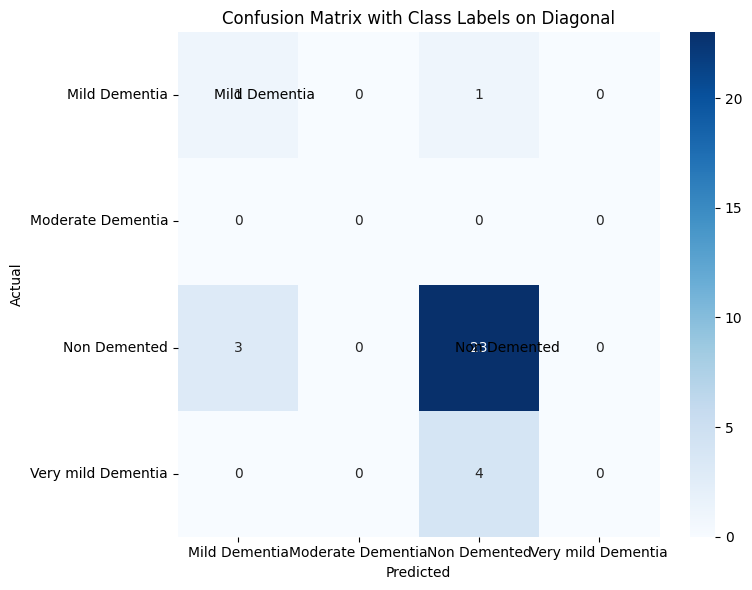

In [20]:
# Evaluation: Classification Report + Confusion Matrix
val_imgs, val_lbls = val_gen.__getitem__(0)
pred_probs = model.predict(val_imgs)
pred_labels = np.argmax(pred_probs, axis=1)
true_labels = np.argmax(val_lbls, axis=1)

# Handle possible missing classes
label_list = list(range(len(le.classes_)))

# Classification Report
print("Classification Report:\n", classification_report(
    true_labels, pred_labels,
    labels=label_list,
    target_names=le.classes_,
    zero_division=0
))

# Confusion Matrix with fixed labels
cm = confusion_matrix(true_labels, pred_labels, labels=label_list)

# Confusion Matrix Plot with diagonal labels
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)

# Add diagonal class names (where applicable)
for i in range(len(le.classes_)):
    if cm[i][i] > 0:
        plt.text(i + 0.3, i + 0.5, le.classes_[i],
                 fontsize=10, color='black', va='center')

plt.title("Confusion Matrix with Class Labels on Diagonal")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()



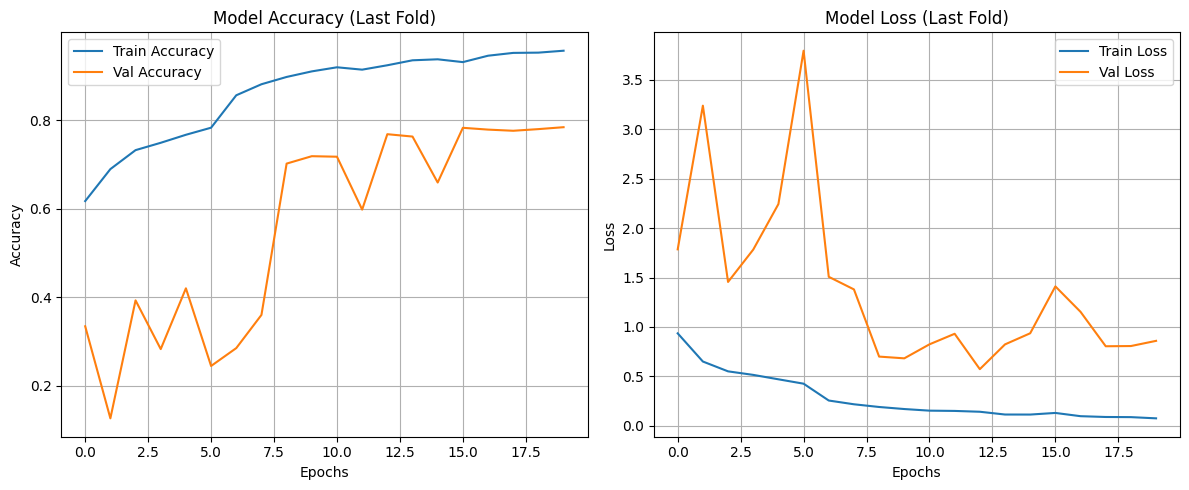

In [22]:
# Plot Accuracy and Loss for the last fold
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy (Last Fold)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss (Last Fold)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [30]:
def get_gradcam_heatmap(model, image, class_idx):
    last_conv_layer_name = [layer.name for layer in model.layers if 'conv' in layer.name][-1]
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(tf.expand_dims(image, axis=0))
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)[0]
    weights = tf.reduce_mean(grads, axis=(0, 1))
    cam = np.dot(conv_outputs[0], weights.numpy())
    cam = np.maximum(cam, 0)
    cam = cam / (cam.max() + 1e-8)
    cam = cv2.resize(cam, (IMG_SIZE, IMG_SIZE))
    return cam



def grad_cam_explanation(image, class_idx):
    cam = get_gradcam_heatmap(model, image, class_idx)
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    superimposed_img = cv2.addWeighted(image, 0.6, heatmap, 0.4, 0)
    return superimposed_img



def predict_mri_with_gradcam(image):
    img_resized = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    img_norm = img_resized / 255.0
    img_expanded = np.expand_dims(img_norm, axis=0)

    pred = model.predict(img_expanded)[0]
    class_idx = np.argmax(pred)
    class_name = le.inverse_transform([class_idx])[0]
    confidence = np.max(pred) * 100

    gradcam_img = grad_cam_explanation(img_resized, class_idx)

    suggestions = {
        "NonDemented": "No signs of Alzheimer’s. Maintain cognitive health.",

        "VeryMildDemented": "Very mild signs. Consider regular checkups.",
        "MildDemented": "Mild dementia detected. Schedule a consultation.",
        "ModerateDemented": "Moderate dementia. Seek medical attention immediately."
    }

    return f"Prediction: {class_name}\nConfidence: {confidence:.2f}%\n\nSuggestion: {suggestions[class_name]}", gradcam_img

# 🎛️ Launch Gradio Interface
interface = gr.Interface(fn=predict_mri_with_gradcam,
                         inputs=gr.Image(type="numpy", label="Upload MRI Scan"),
                         outputs=[gr.Textbox(label="Prediction & Suggestions"),
                                  gr.Image(label="Grad-CAM Heatmap")],
                         title="🧠 Alzheimer MRI Classifier (MobileNetV2 Only)",
                         description="Upload an MRI scan to classify Alzheimer's stage with confidence score and Grad-CAM visualization.")
interface.launch(share=True)



Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://c147480a3d3f22ba0d.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
